In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

#modelling
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings


In [6]:
df = pd.read_csv('data\Stud_performance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [7]:
X = df.drop(columns=["math score"], axis =1)
y = df['math score']

In [8]:
X.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [9]:
# Seperated categorical and numerical columns
n_features = [feature for feature in df.columns if df[feature].dtype != 'O'  and feature != 'math score']
c_features = [feature for feature in df.columns if df[feature].dtype =='O']
# n_features = X.select_dtypes(exclude="object").columns
# c_features = X.select_dtypes(include="object").columns
print(n_features) 
c_features


['reading score', 'writing score']


['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
OneHot_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",OneHot_transformer,c_features),
        ("StandardScaler",numeric_transformer, n_features)
    ]
)

In [11]:
X = preprocessor.fit_transform(X)

In [12]:
X

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.19399858,  0.39149181],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.42747598,  1.31326868],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.77010859,  1.64247471],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.12547206, -0.20107904],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.60515772,  0.58901542],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         1.15336989,  1.18158627]])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

# Created an evaluate function to know all the metrics

In [14]:
def evaluate_model(true,predicted):
    mae = mean_absolute_error(true,predicted)
    mse = mean_squared_error(true,predicted)
    rmse = np.sqrt(mean_squared_error(true,predicted))
    r2_square = r2_score(true,predicted)
    
    return mae,mse,rmse,r2_square



In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}

params = {
    "Decision Tree": {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Random Forest Regressor": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "XGBRegressor": {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 9]
    },
    "K-Neighbors Regressor": {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    },
    "AdaBoost Regressor": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2]
    },
    "Linear Regressor":{}
}

model_list = []
r2_List_test = []
r2_list_train = []

for model_name, model in models.items():
    print(f"Training {model_name}...")

    if model_name in params:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params[model_name],
            n_iter=30,
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        search.fit(X_train, y_train)
        model = search.best_estimator_
        print(f"Best params for {model_name}: {search.best_params_}")

    else:
        model.fit(X_train, y_train)

    # Make the predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate the model
    model_train_mae, model_train_rmse, model_train_r2, model_train_mse = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2, model_test_mse = evaluate_model(y_test, y_test_pred)

    print("\nModel performance for training set")
    print(f"Root Mean Squared Error: {model_train_rmse:.4f}")
    print(f"Mean Absolute Error: {model_train_mae:.4f}")
    print(f"Mean Squared Error: {model_train_mse:.4f}")
    print(f"R² score: {model_train_r2:.4f}")
    print("\n-------------------------------")
    print("\nModel performance for test set")
    print(f"Root Mean Squared Error: {model_test_rmse:.4f}")
    print(f"Mean Absolute Error: {model_test_mae:.4f}")
    print(f"Mean Squared Error: {model_test_mse:.4f}")
    print(f"R² score: {model_test_r2:.4f}")
    print("\n-------------------------------")

    # Store the results
    model_list.append(model_name)
    r2_List_test.append(model_test_r2)
    r2_list_train.append(model_train_r2)

print("Model List:", model_list)
print("R² Scores on Test Set:", r2_List_test)
print("R² Scores on Training Set:", r2_list_train)

Training Linear Regression...

Model performance for training set
Root Mean Squared Error: 28.3808
Mean Absolute Error: 4.2788
Mean Squared Error: 0.8741
R² score: 5.3274

-------------------------------

Model performance for test set
Root Mean Squared Error: 29.2638
Mean Absolute Error: 4.2259
Mean Squared Error: 0.8797
R² score: 5.4096

-------------------------------
Training Lasso...

Model performance for training set
Root Mean Squared Error: 43.4784
Mean Absolute Error: 5.2063
Mean Squared Error: 0.8071
R² score: 6.5938

-------------------------------

Model performance for test set
Root Mean Squared Error: 42.5064
Mean Absolute Error: 5.1579
Mean Squared Error: 0.8253
R² score: 6.5197

-------------------------------
Training Ridge...

Model performance for training set
Root Mean Squared Error: 28.3378
Mean Absolute Error: 4.2650
Mean Squared Error: 0.8743
R² score: 5.3233

-------------------------------

Model performance for test set
Root Mean Squared Error: 29.0563
Mean Ab

c:\Users\018017\OneDrive - Sify Technologies Limited\Documents\ineuron\ML_Project\ml_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 10 is smaller than n_iter=30. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for K-Neighbors Regressor: {'weights': 'distance', 'n_neighbors': 11}

Model performance for training set
Root Mean Squared Error: 0.0781
Mean Absolute Error: 0.0188
Mean Squared Error: 0.9997
R² score: 0.2795

-------------------------------

Model performance for test set
Root Mean Squared Error: 51.5183
Mean Absolute Error: 5.5842
Mean Squared Error: 0.7883
R² score: 7.1776

-------------------------------
Training Decision Tree...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params for Decision Tree: {'min_samples_split': 5, 'max_depth': 5, 'criterion': 'squared_error'}

Model performance for training set
Root Mean Squared Error: 32.6874
Mean Absolute Error: 4.6396
Mean Squared Error: 0.8550
R² score: 5.7173

-------------------------------

Model performance for test set
Root Mean Squared Error: 42.7716
Mean Absolute Error: 4.9315
Mean Squared Error: 0.8242
R² score: 6.5400

-------------

c:\Users\018017\OneDrive - Sify Technologies Limited\Documents\ineuron\ML_Project\ml_env\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for AdaBoost Regressor: {'n_estimators': 200, 'learning_rate': 0.2}

Model performance for training set
Root Mean Squared Error: 34.3636
Mean Absolute Error: 4.7921
Mean Squared Error: 0.8476
R² score: 5.8621

-------------------------------

Model performance for test set
Root Mean Squared Error: 36.9969
Mean Absolute Error: 4.7357
Mean Squared Error: 0.8480
R² score: 6.0825

-------------------------------
Model List: ['Linear Regression', 'Lasso', 'Ridge', 'K-Neighbors Regressor', 'Decision Tree', 'Random Forest Regressor', 'XGBRegressor', 'AdaBoost Regressor']
R² Scores on Test Set: [5.40960336750764, 6.51969453566742, 5.390387016935638, 7.177626107603356, 6.540000789493743, 5.903515547221972, 5.661136062500646, 6.0825074121315]
R² Scores on Training Set: [5.327359474652332, 6.593815587795566, 5.323324922741654, 0.27950849718949117, 5.71728864854146, 3.9768276691191824, 4.726288659884577, 5.862050091357519]


# Results

In [16]:
import pandas as pd

df_results = pd.DataFrame({
    "Model Name": model_list,
    "Train R2 Score": r2_list_train,
    "Test R2 Score": r2_List_test
})
df_results["Difference"] = (df_results["Train R2 Score"] - df_results["Test R2 Score"]).abs()

pd.options.display.float_format = '{:.6f}'.format

df_results

,Model Name,Train R2 Score,Test R2 Score,Difference
0,Linear Regression,5.327359,5.409603,0.082244
1,Lasso,6.593816,6.519695,0.074121
2,Ridge,5.323325,5.390387,0.067062
3,K-Neighbors Regressor,0.279508,7.177626,6.898118
4,Decision Tree,5.717289,6.540001,0.822712
5,Random Forest Regressor,3.976828,5.903516,1.926688
6,XGBRegressor,4.726289,5.661136,0.934847
7,AdaBoost Regressor,5.862050,6.082507,0.220457


# Linear Regression score

In [22]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test,y_pred)*100
print("Accuracy of Linear Regression Model : %.2f" %score)

Accuracy of Linear Regression Model : 87.97


# plotting y_pred and y_test

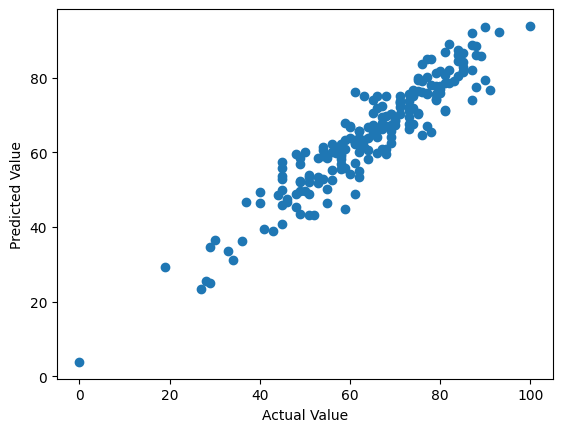

In [19]:
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()

<Axes: xlabel='math score'>

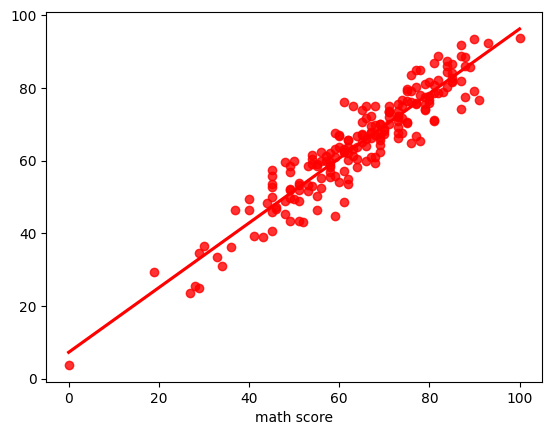

In [20]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='red')

In [21]:
Lasso_model = Lasso(fit_intercept=True)
Lasso_model.fit(X_train, y_train)
y_pred = Lasso_model.predict(X_test)
score = r2_score(y_test,y_pred)*100
print("Accuracy for Lasso model : %.2f" %score)

Accuracy for Lasso model : 82.53
